In [2]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np

# Exploring
import scipy.stats as stats

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

import wrangle_functions
import env
import acquire
import summarize
# import prepare

In [6]:
# use mallcustomers;

def get_connection(db, username=env.username, host=env.host, password=env.password):
    return f'mysql+pymysql://{username}:{password}@{host}/{db}'
    
def get_mallcustomer_data():
    df = pd.read_sql('SELECT * FROM customers;', get_connection('mall_customers'))
    return df.set_index('customer_id')

1. Only include properties with a transaction in 2017, and include only the last transaction for each property (so no duplicate property ID's), along with zestimate error and date of transaction.`m

In [7]:
df = get_mallcustomer_data()

In [8]:
summarize.summarize(df)



Dataframe head: 
|   customer_id | gender   |   age |   annual_income |   spending_score |
|--------------:|:---------|------:|----------------:|-----------------:|
|             1 | Male     |    19 |              15 |               39 |
|             2 | Male     |    21 |              15 |               81 |
|             3 | Female   |    20 |              16 |                6 |


Dataframe info: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB
None


Dataframe Description: 
|       |     age |   annual_income |   spending_score |
|:------|--------:|----------------:|-----------------:|
| count | 200     |        20

NameError: name 'nulls_by_col' is not defined

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [10]:
df.describe()

,age,annual_income,spending_score
count,200.00,200.00,200.00
mean,38.85,60.56,50.20
std,13.97,26.26,25.82
min,18.00,15.00,1.00
25%,28.75,41.50,34.75
50%,36.00,61.50,50.00
75%,49.00,78.00,73.00
max,70.00,137.00,99.00


In [11]:
df.dtypes

gender            object
age                int64
annual_income      int64
spending_score     int64
dtype: object

In [12]:
df.columns

Index(['gender', 'age', 'annual_income', 'spending_score'], dtype='object')

In [14]:
wrangle_functions.nulls_by_col(df)

,num_rows_missing,percent_rows_missing
gender,0,0.00
age,0,0.00
annual_income,0,0.00
spending_score,0,0.00


In [15]:
wrangle_functions.nulls_by_row(df)

,num_cols_missing,percent_cols_missing,num_rows
0,0,0.0,200


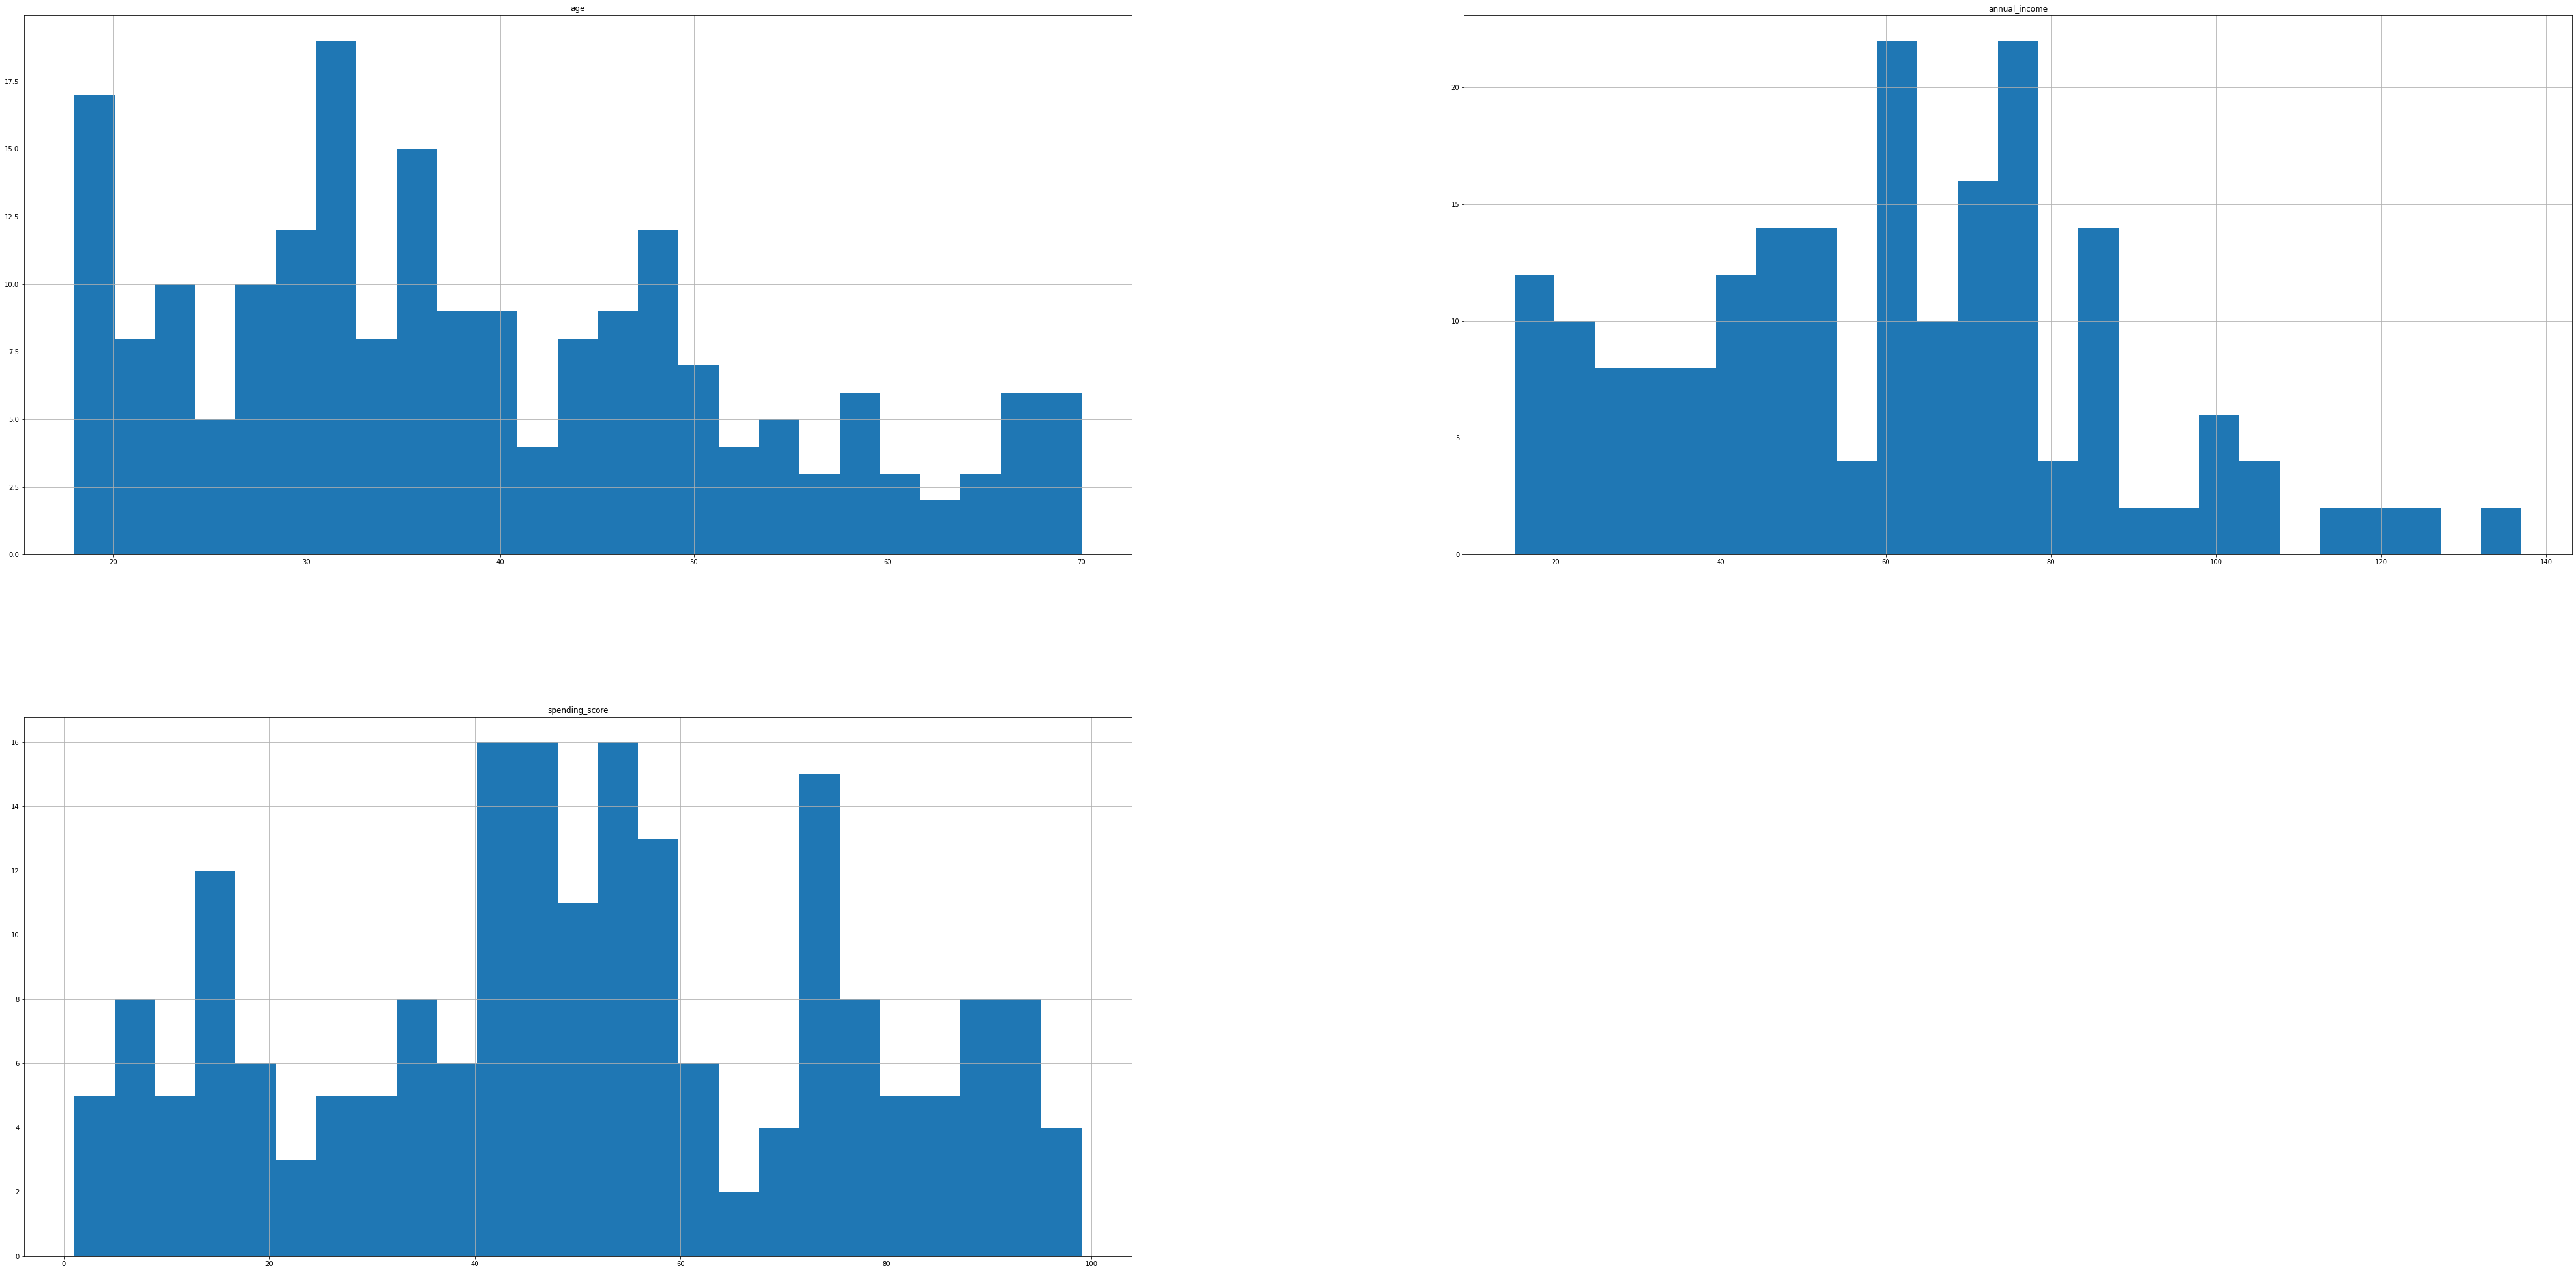

In [18]:
df.hist(figsize=(70, 35), bins=25)
plt.show()

** Takeaways **
spending score and annual income are not normally distributed and I don't take anything away from this dist. fig.
age is right skewed

In [20]:
# how many null values are in the columns we chose to keep
wrangle_functions.nulls_by_col(df)

,num_rows_missing,percent_rows_missing
gender,0,0.00
age,0,0.00
annual_income,0,0.00
spending_score,0,0.00


In [21]:
#outlier
df = df.loc[:,~df.columns.duplicated()]

In [22]:
def get_upper_outliers(s, k=1.5):
    q1, q3 = s.quantile([.25, 0.75])
    iqr = q3 - q1
    upper_bound = q3 + k * iqr
    return s.apply(lambda x: max([x - upper_bound, 0]))

In [23]:
def add_upper_outlier_columns(df, k=1.5):
    for col in df.select_dtypes('number'):
        df[col + '_outliers_upper'] = get_upper_outliers(df[col], k)
    return df

In [24]:
df = add_upper_outlier_columns(df)

In [25]:
df.head()

,gender,age,annual_income,spending_score,age_outliers_upper,annual_income_outliers_upper,spending_score_outliers_upper
customer_id,,,,,,,
1,Male,19,15,39,0,0.00,0
2,Male,21,15,81,0,0.00,0
3,Female,20,16,6,0,0.00,0
4,Female,23,16,77,0,0.00,0
5,Female,31,17,40,0,0.00,0


In [26]:
outlier_cols = [col for col in df.columns if col.endswith('_outliers_upper')]
for col in outlier_cols:
    print(col, ': ')
    subset = df[col][df[col] > 0]
    print(subset.describe())

age_outliers_upper : 
count                   0.00
mean                     NaN
std                      NaN
min                      NaN
25%                      NaN
50%                      NaN
75%                      NaN
max                      NaN
Name: age_outliers_upper, dtype: float64
annual_income_outliers_upper : 
count                   2.00
mean                    4.25
std                     0.00
min                     4.25
25%                     4.25
50%                     4.25
75%                     4.25
max                     4.25
Name: annual_income_outliers_upper, dtype: float64
spending_score_outliers_upper : 
count                   0.00
mean                     NaN
std                      NaN
min                      NaN
25%                      NaN
50%                      NaN
75%                      NaN
max                      NaN
Name: spending_score_outliers_upper, dtype: float64


In [ ]:
# I am choosing not to drop the outliers in income as they might be true values since income varies greatly